### Training Clock Validation Models

This file mainly prepars models which can identify regoins in a clock dataset where a fail state occured in time of TempCo testing.

#### Imports

In [1]:
# PyTorch
import torch, os
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler


# Custom functions and classes
from dataHandler import ClockDataset
from classifiers import PtClassifier_V2

device = "cuda" if torch.cuda.is_available() else "cpu"

#### Prepare Clock Dataset

TempCo data: clock data collected during clock testing undergoing temperature cycling over the course of a set period of time.

In [2]:
# Paths containing testing and training datasets
TEST_DATASET  = os.path.join(os.getcwd(), r"data\test")
TRAIN_DATASET = os.path.join(os.getcwd(), r"data\train")
BATCH_SIZE = 1

# Creating Datasets
clock_dataset_test = ClockDataset(f_data=TEST_DATASET, transform=False)
clock_dataset_train = ClockDataset(f_data=TRAIN_DATASET, transform=False)

# Creating Dataloaders
train_dataloader = DataLoader(
    dataset=clock_dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=3)

test_dataloader = DataLoader(
    dataset=clock_dataset_test,
    drop_last=True,
    batch_size=BATCH_SIZE,
    num_workers=3)

print(f"Number of clocks in train dataset: {clock_dataset_train.__len__()}")
print(f"Number of clocks in test dataset: {clock_dataset_test.__len__()}")

Number of clocks in train dataset: 117
Number of clocks in test dataset: 18


In [3]:
# Sample data
sample_param, sample_labels, sample_columns, sample_validation = next(iter(train_dataloader))

print(f"Sample Parameter row:\n{sample_param[0][0]}")
print(f"Sample Label: {sample_labels[0][0]}")
print(f"Sample Columns: {sample_columns}")
print(f"Sample Validation: {sample_validation[0]}")

print(f"Length of sample parameters: {len(sample_param[0])}")

Sample Parameter row:
tensor([7.7110e-01, 3.3155e+04, 1.4454e+04, 9.4020e+03, 5.0520e+03, 1.2371e+00,
        3.2601e+04, 3.3725e+04, 3.4031e+01, 9.1219e+01, 8.4200e+01, 4.0498e+04,
        4.0624e+04, 3.0653e+04, 5.4500e+02])
Sample Label: tensor([0])
Sample Columns: [('DCL',), ('PDADC',), ('CPTP',), ('CPTF',), ('CPTD',), ('VBC',), ('VFA',), ('XFA',), ('TPCB',), ('VTEMP',), ('CTEMP',), ('VHTR',), ('CHTR',), ('RFL',), ('PDSU',), ('FAIL',)]
Sample Validation: pass
Length of sample parameters: 158744


Testing batch dimmensions on a clock dataset.

NOTE: Batch dimmensions in the clock dataloader have dim issues that still need to be sorted out.

In [4]:
clock_data = sample_param[0]

# Create a batch_size of 64
batches = []
for row in range(0, len(clock_data), 128):
    batch = clock_data[row:row+8]
    batches.append(batch)

print(len(batches))

1241


#### Import Model

In [5]:
NUM_PARAMS  = clock_dataset_train[0][0][0].__len__()
NUM_CLASSES = clock_dataset_train[0][1][0].__len__()
model = PtClassifier_V2(parameters=NUM_PARAMS, classes=NUM_CLASSES)
model = model.to(device)
print(f"Number of parameters for model input: {NUM_PARAMS}")
print(f"Number of classes: {NUM_CLASSES}")

Number of parameters for model input: 15
Number of classes: 1


#### Optimizer and Loss Function

In [6]:
optimizer = optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

#### Training
Note:
    Models take a long time to train ~6 min per clock.
    This is because we are trainning the models on each second of data per clockk.
    Training time can be improved by reducing the datasets by factoring out:
        - Data where clock is idle 
        - Introduce a batch parameter when training per clock to train on batches of seconds   

In [7]:
from engine import train_batch, train_across_clock_dataset
NUM_EPOCHS = 10

trn_l, trn_a, tst_l, tst_a = train_across_clock_dataset(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    model=model,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    epochs=NUM_EPOCHS,
    skip_pass_dataset=False
)

''' 
    Implement batch size per training and testing step per clock to reduce training time.
'''

Model Training
Clock 116 | fail | Loss: 0.00 | Acc: 0.98 | Acc: 0.89
Model Testing


' \n    Implement batch size per training and testing step per clock to reduce training time.\n'

Saving the model

In [8]:
model.save(os.path.join(os.getcwd()), 5)

Model saved to: c:\Users\btehrani\Documents\Repos\vsCode\CSAC\src/models/csac_ml_5.pth


In [10]:
model  = torch.load(r"c:\Users\btehrani\Documents\Repos\vsCode\CSAC\src/models/csac_ml_5.pth")
model = model.to(device)
# Sample data
sample_param, sample_labels, sample_columns, sample_validation = next(iter(train_dataloader))
t = sample_param[0].to(device)
test_labels = model(t)
y_preds_batch_train = torch.round(torch.sigmoid(test_labels)).to(torch.int64)

accuracy = torch.sum(torch.eq(y_preds_batch_train, sample_labels[0].to(device))).item()

print(f"Accuracy: {accuracy/len(sample_labels[0])}")

print(y_preds_batch_train)
print(sample_labels[0])

Accuracy: 1.0
tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]], device='cuda:0')
tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])


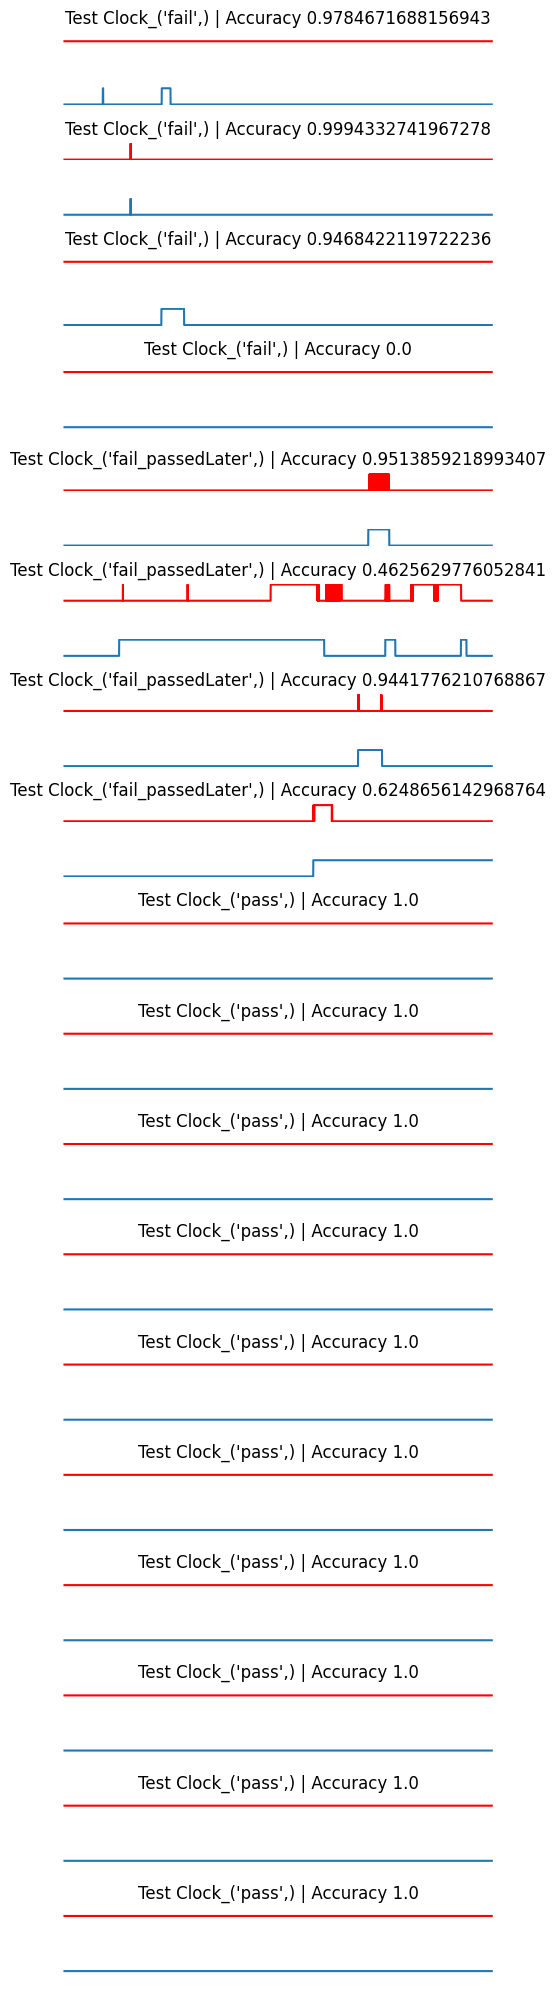

In [12]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2*clock_dataset_test.__len__(), ncols=1, figsize=(5, 20))
i=0
for clock_data, labels, _, validation in test_dataloader:

    preds = model(clock_data[0].to(device))
    
    pred_labels = torch.where(preds > 0, 1, 0).to(torch.int64)
    acc = torch.sum(torch.eq(pred_labels, labels[0].to(device))).item()

    ax[i].plot(pred_labels.cpu().numpy(), c='r')
    ax[i].axis("off")
    ax[i].set_title(f'Test Clock_{validation} | Accuracy {acc/len(labels[0])}')
    ax[i+1].plot(labels[0])
    ax[i+1].axis("off")
    i = i+2
plt.tight_layout()


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].plot(y_preds_batch_train.cpu())
ax[0].set_title("Prediction")

ax[1].plot(sample_labels[0])
ax[1].set_title("Actual")
plt.tight_layout()

